# CryoCRAB Full-Diff H5 Pair

This script shows how to convert Full-Diff MRC Pair into Full-Diff H5 Pair and how to use h5 file.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys, os
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"{project_root = }")
from CryoCRAB import *
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger("pymongo").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("h5py").setLevel(logging.WARNING)
logging.getLogger("numba").setLevel(logging.WARNING)
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
project_root = '/home/vrlab/code/Cryo/CryoCRAB-Scripts'


## Prepare Test Data & Metadata

In [6]:
full_mrc_path = "/home/vrlab/code/Cryo/CryoCRAB-Scripts/Data/049461_empiar_10736_full.mrc"
diff_mrc_path = "/home/vrlab/code/Cryo/CryoCRAB-Scripts/Data/049461_empiar_10736_diff.mrc"
defocus_u = 25241.60546875
defocus_v = 24660.130859375
defocus_angle_rad = 0.026702193543314934
accel_kv = 300
cs_mm = 2.7
amp_contrast = 0.1
phase_shift_rad = 0
psize_in = 1.365

In [7]:
# Bin1 MRC Full
with mrcfile.open(full_mrc_path) as mrc:
    bin1_full = mrc.data.copy().astype(np.float32) # even + odd
# Bin1 MRC Diff
with mrcfile.open(diff_mrc_path) as mrc:
    bin1_dif  = mrc.data.copy().astype(np.float32) # even - odd

## Full-Diff H5 Pair Generation

In [9]:
from CryoCRAB.utils.fft_sizes import get_shapes_for_desired_psize
from CryoCRAB.utils import fft
from CryoCRAB.utils.micrograph import pad_mic_with_mean, trim_mic, contrast_normalization, estimate_subtract_background
from CryoCRAB.utils.ctf import compute_ctf

frame_shape_in = bin1_full.shape
desired_psize_A = 3.0
N_in, N_out, psize_out, downfactor, frame_shape_out = get_shapes_for_desired_psize(psize_in, frame_shape_in, desired_psize_A)

# subtract background
bin1_full = estimate_subtract_background(
    bin1_full,
    psize=psize_in,
)

do_fcrop = lambda x : fft.ZT( fft.rfft2_center( pad_mic_with_mean(x, N_in) ), N_out )
do_ifft_trim = lambda x : trim_mic( fft.irfft2_center( x ), frame_shape_out)

bin1_even = (bin1_full + bin1_dif) * 0.5
bin1_odd = (bin1_full - bin1_dif) * 0.5

bin3A_even_ft = do_fcrop(bin1_even)
bin3A_odd_ft = do_fcrop(bin1_odd)

freqs_3A = fft.get_rfft_center_freqs((N_out, N_out), psize_out) # Freqs 
ctffilt = compute_ctf( # Prepare CTF Filter
    defocus_u=defocus_u,
    defocus_v=defocus_v,
    defocus_angle_rad=defocus_angle_rad,
    accel_kv=accel_kv,
    cs_mm=cs_mm,
    amp_contrast=amp_contrast,
    phase_shift_rad=phase_shift_rad,
    freqs=freqs_3A,
    N_out=N_out,
    psize_out=psize_out,
)

bin3A_even_ft = bin3A_even_ft * ctffilt
bin3A_odd_ft = bin3A_odd_ft * ctffilt

bin3A_even = do_ifft_trim(bin3A_even_ft)
bin3A_odd = do_ifft_trim(bin3A_odd_ft)

even_vmin, even_vmax = contrast_normalization(bin3A_even)
odd_vmin, odd_vmax = contrast_normalization(bin3A_odd)

bin3A_even = bin3A_even.clip(even_vmin, even_vmax)
bin3A_odd = bin3A_odd.clip(odd_vmin, odd_vmax)

bin3A_full = bin3A_even + bin3A_odd
bin3A_diff = bin3A_even - bin3A_odd

bin3A_full_vmin, bin3A_full_vmax = contrast_normalization(bin3A_full)
bin3A_full = bin3A_full.clip(bin3A_full_vmin, bin3A_full_vmax)

with h5py.File("../Data/test.h5", 'w') as f:
    f.attrs['even_vmin'] = even_vmin
    f.attrs['even_vmax'] = even_vmax
    f.attrs['odd_vmin'] = odd_vmin
    f.attrs['odd_vmax'] = odd_vmax
    f.attrs['full_vmin'] = bin3A_full_vmin
    f.attrs['full_vmax'] = bin3A_full_vmax
    
    bin3A_full = bin3A_full.clip(-65504, 65504)
    bin3A_diff = bin3A_diff.clip(-65504, 65504)
    
    f.create_dataset('full', shape=frame_shape_out, data=bin3A_full.astype(np.float16), dtype=np.float16, chunks=(256, 256), compression=None)
    f.create_dataset('diff', shape=frame_shape_out, data=bin3A_diff.astype(np.float16), dtype=np.float16, chunks=(256, 256), compression=None)
    
    full_mean, full_std = np.nanmean(bin3A_full), np.nanstd(bin3A_full)
    even_mean, even_std = np.nanmean(bin3A_even), np.nanstd(bin3A_even)
    odd_mean, odd_std = np.nanmean(bin3A_odd), np.nanstd(bin3A_odd)
    
    f.attrs['full_mean'] = full_mean
    f.attrs['full_std'] = full_std
    f.attrs['even_mean'] = even_mean
    f.attrs['even_std'] = even_std
    f.attrs['odd_mean'] = odd_mean
    f.attrs['odd_std'] = odd_std

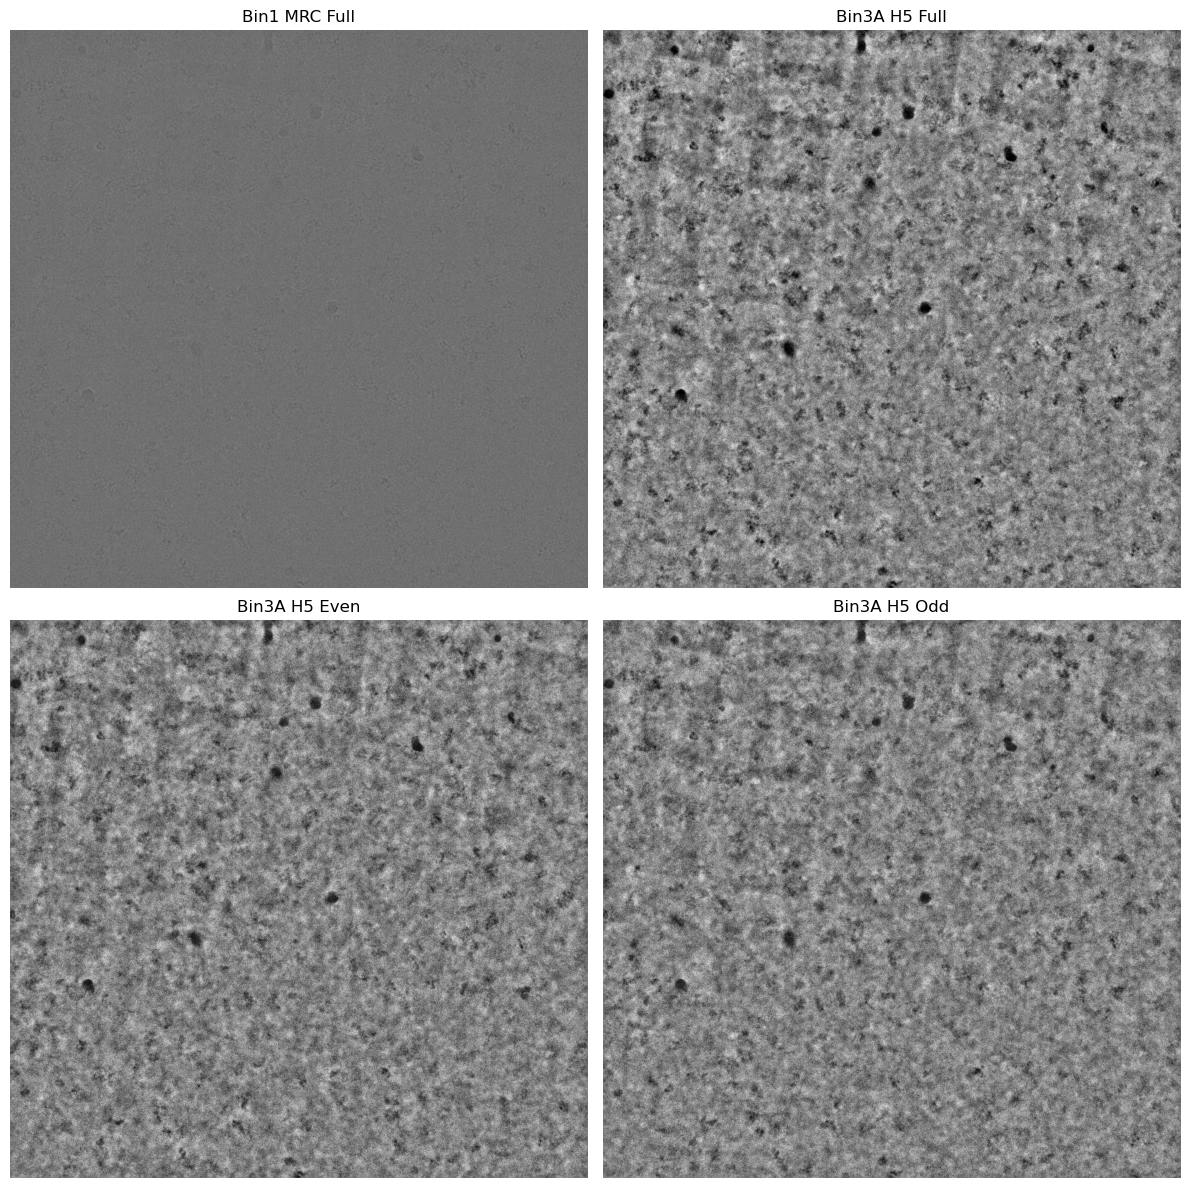

In [17]:
# Bin1 MRC Full
with mrcfile.open(full_mrc_path) as mrc:
    bin1_full = mrc.data.copy().astype(np.float32) # even + odd
    bin1_full = (bin1_full - bin1_full.mean()) / bin1_full.std()
with h5py.File("../Data/test.h5", "r") as f:
    bin3A_full = f['full'][()].astype(np.float32) # Bin3A H5 Full
    bin3A_diff = f['diff'][()].astype(np.float32) # Bin3A H5 Diff
    bin3A_even = (bin3A_full + bin3A_diff) * 0.5
    bin3A_odd = (bin3A_full - bin3A_diff) * 0.5
    full_mean, full_std = f.attrs['full_mean'], f.attrs['full_std']
    even_mean, even_std = f.attrs['even_mean'], f.attrs['even_std']
    odd_mean, odd_std = f.attrs['odd_mean'], f.attrs['odd_std']
    bin3A_full = (bin3A_full - full_mean) / full_std
    bin3A_even = (bin3A_even - even_mean) / even_std
    bin3A_odd = (bin3A_odd - odd_mean) / odd_std
    
# Visualize Bin1 MRC Full, Bin3A H5 Full, Bin3A H5 Even, Bin3A H5 Odd
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot images
images = [bin1_full, bin3A_full, bin3A_even, bin3A_odd]
titles = ['Bin1 MRC Full', 'Bin3A H5 Full', 'Bin3A H5 Even', 'Bin3A H5 Odd']

for ax, img, title in zip(axes[0:2, :].flatten(), images, titles):
    im = ax.imshow(img, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()